# What factors influence cancer patient survival?

The objective of this task will be to determine what types of cancer patients succumb more quickly to cancer, and what aspects of the cancer may be more indicative of this. To do so, this task will model various features of patients with cancer and attempt to predict patient survival months, comparing models to determine which features are most influential in predicting patient survival accurately, especially since in this dataset, survival months is represented as an integer.

# Preliminary Work

### Import Libraries / Data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from matplotlib import rcParams
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
#df = pd.read_csv('fulldata2.csv')
df = pd.read_csv('smallersample2.csv')
#Read in data as pandas dataframe. Data is SEER registry data uploaded 2021, contains information on people with cancer. This is somewhat truncated since the original had far too many points to process in a reasonable amount of time.
#Smaller sample is random sample of data from the full data, since full data is too large.
df = df.drop('Unnamed: 0',axis=1)

### Data Preparation

In [3]:
df = df.dropna()
df = df.set_index('Patient ID')

In [4]:
df.head()
#See top few columns of data to get an idea of contents.

,Age recode with <1 year olds,Sex,Year of diagnosis,"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Site recode ICD-O-3/WHO 2008,Combined Summary Stage (2004+),Summary stage 2000 (1998-2017),Brain Molecular Markers (2018+),COD to site recode,SEER cause-specific death classification,SEER other cause of death classification,Survival months,Survival months flag,Sequence number,Behavior code ICD-O-3,Primary Site,Diagnostic Confirmation,Median household income inflation adj to 2019
Patient ID,,,,,,,,,,,,,,,,,,
1278657,65-69 years,Male,2012,Non-Hispanic White,Melanoma of the Skin,In situ,In situ,Blank(s),Alive,Alive or dead of other cause,Alive or dead due to cancer,0085,Complete dates are available and there are mor...,One primary only,In situ,446,Positive histology,"$75,000+"
36664370,75-79 years,Male,2017,Non-Hispanic Unknown Race,Melanoma of the Skin,Unknown/unstaged,Unknown/unstaged,Blank(s),Alive,Alive or dead of other cause,Alive or dead due to cancer,0034,Complete dates are available and there are mor...,One primary only,Malignant,443,Positive histology,"$75,000+"
9207086,55-59 years,Female,2017,Non-Hispanic Asian or Pacific Islander,Corpus Uteri,Localized,Localized,Blank(s),Soft Tissue including Heart,Dead (attributable to this cancer dx),Alive or dead due to cancer,0016,Complete dates are available and there are mor...,One primary only,Malignant,543,Positive histology,"$75,000+"
9136572,80-84 years,Male,2012,Non-Hispanic Asian or Pacific Islander,Lung and Bronchus,Distant,Distant,Blank(s),Lung and Bronchus,Dead (attributable to this cancer dx),Alive or dead due to cancer,0001,Complete dates are available and there are mor...,One primary only,Malignant,341,Positive histology,"$75,000+"
26415389,50-54 years,Male,2002,Non-Hispanic White,Brain,Blank(s),Localized,Blank(s),Brain and Other Nervous System,Dead (attributable to this cancer dx),Alive or dead due to cancer,0012,Complete dates are available and there are mor...,One primary only,Malignant,710,Positive histology,"$60,000 - $64,999"


In [5]:
df.info()
#See information to determine what may need to be cleaned up / processed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21194 entries, 1278657 to 62029770
Data columns (total 18 columns):
 #   Column                                                      Non-Null Count  Dtype 
---  ------                                                      --------------  ----- 
 0   Age recode with <1 year olds                                21194 non-null  object
 1   Sex                                                         21194 non-null  object
 2   Year of diagnosis                                           21194 non-null  int64 
 3   Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)  21194 non-null  object
 4   Site recode ICD-O-3/WHO 2008                                21194 non-null  object
 5   Combined Summary Stage (2004+)                              21194 non-null  object
 6   Summary stage 2000 (1998-2017)                              21194 non-null  object
 7   Brain Molecular Markers (2018+)                             21194 non-null  object
 8

### Cleanup data. Represent objects as floats or integers as possible.

Age

In [6]:
df['Age recode with <1 year olds'].unique()
#See unique values for 'Age' feature, to figure out how to organize.

array(['65-69 years', '75-79 years', '55-59 years', '80-84 years',
       '50-54 years', '60-64 years', '40-44 years', '70-74 years',
       '45-49 years', '85+ years', '35-39 years', '30-34 years',
       '25-29 years', '20-24 years', '05-09 years', '00 years',
       '01-04 years', '15-19 years', '10-14 years'], dtype=object)

In [7]:
#Organize 'Age' by assigning each age range to its average as an approximate age.

def AgeReassign(String):
    temp = String.replace(' years','')
    #Remove the text 'years' from the string as it is in all the categories.
    if '-' in temp:
    #First type of category has a '-' in it, to denote the range of the years. So address this case first.
        return(sum([float(i) for i in temp.split('-')]) / 2)
        #Return the average of each pair of numbers. temp.split('-') separates the string into the two numerical halves. Then float(i) replaces the string with a float so that operations can be performed on it.
    elif '+' in temp:
    #Only one category of this, and it only has one number, address this type of label.
        return(float(temp.split('+')[0]))
        #Return this age. Should note that this means any age 85 and above will end up being labelled as 85.
    else:
        return(float(0))
        #The only othe category is '00 years', so for convinience, will simply return 0.
        
df['Age recode with <1 year olds'] = df['Age recode with <1 year olds'].apply(AgeReassign)
#Replace previous 'Age Recode' with the reassigned version.

Sex

In [8]:
df['Sex'].unique()

array(['Male', 'Female'], dtype=object)

In [9]:
#Map 'Female' to 0 and 'Male' to 1, since this category is binary.
#Replace the column with this binary one.
df['Sex'] = df['Sex'].map({'Female':0,'Male':1})


Race / Origin

In [10]:
df['Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)'].unique()

array(['Non-Hispanic White', 'Non-Hispanic Unknown Race',
       'Non-Hispanic Asian or Pacific Islander', 'Hispanic (All Races)',
       'Non-Hispanic Black', 'Non-Hispanic American Indian/Alaska Native'],
      dtype=object)

In [11]:
onehotlist = []
#Create list to use with onehotencoder later

In [12]:
onehotlist.append('Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)')
#Append patient race to onehotlist, since these race categories can't be put into any particular order.

Site of Cancer

In [174]:
len(df['Site recode ICD-O-3/WHO 2008'].unique())
#May be difficult to use, as there is a large number of categories.

80

In [14]:
onehotlist.append('Site recode ICD-O-3/WHO 2008')
#Append site of cancer to onehotlist, since these are categories that can't really be put in an order.

Combined Summary Stage

In [15]:
df['Combined Summary Stage (2004+)'].unique()

array(['In situ', 'Unknown/unstaged', 'Localized', 'Distant', 'Blank(s)',
       'Regional', 'Not coded - Testis'], dtype=object)

In [16]:
df= df[df['Combined Summary Stage (2004+)'] != 'Unknown/unstaged']
df= df[df['Combined Summary Stage (2004+)'] != 'Blank(s)']
#Drop unknown values for this. Will use onehotencoder.

In [17]:
onehotlist.append('Combined Summary Stage (2004+)')
#Append cancer stage to onehotlist.

Brain Molecule Markers

In [18]:
df['Brain Molecular Markers (2018+)'].unique()

array(['Blank(s)',
       'NA: Histology not 9400/3, 9401/3, 9440/3, 9450/3, 9451/3, 9471/3, 9478/3',
       'Glioblastoma, IDH-wildtype (9440/3)',
       'Not documented; No microscopic confirmation; Not assessed or unknown if assessed',
       'Anaplastic astrocytoma, IDH-wildtype (9401/3)',
       'Medulloblastoma, SHH-activated and TP53-wildtype (9471/3)'],
      dtype=object)

In [19]:
(df['Brain Molecular Markers (2018+)'] == 'Blank(s)').sum()
#Drop this, there are too many blank values.
df = df.drop('Brain Molecular Markers (2018+)',axis=1)

Cause of death

In [173]:
len(df['COD to site recode'].unique())

88

In [21]:
onehotlist.append('COD to site recode')
#Append cause of death to onehotlist, these can't be put in any particular order.

SEER death classification

In [22]:
df['SEER cause-specific death classification'].unique()
#Only want to look at cancer, so death to other causes not very relevant.

array(['Alive or dead of other cause',
       'Dead (attributable to this cancer dx)',
       'Dead (missing/unknown COD)'], dtype=object)

In [23]:
df  = df[df['SEER cause-specific death classification'] != 'Dead (missing/unknown COD)']
#Drop unknown causes of death, as likely irrelevant to cancer.

In [24]:
df['SEER other cause of death classification'].unique()

array(['Alive or dead due to cancer',
       'Dead (attributable to causes other than this cancer dx)'],
      dtype=object)

In [25]:
df[df['SEER other cause of death classification'] != 'Dead (attributable to causes other than this cancer dx)']
#Remove values where they are dead due to causes other than the cancer, as this is irrelevant to the task.

df = df.drop('SEER other cause of death classification', axis= 1)
#Drop this column, because is now irrelevant with only one value.

Surival Months

In [26]:
df['Survival months'].unique()
#Looks like most can be converted to float. 

array(['0085', '0016', '0001', '0000', '0006', '0011', '0140', '0145',
       '0002', '0039', '0084', '0178', '0106', '0005', '0014', '0008',
       '0022', '0064', '0142', '0080', '0048', '0122', '0160', '0035',
       '0049', '0041', '0125', '0050', '0003', '0058', '0071', '0053',
       '0034', '0172', '0020', '0019', '0007', '0004', '0060', '0112',
       '0017', '0023', '0024', '0018', '0116', '0067', '0109', '0161',
       '0089', '0174', '0076', '0169', '0038', '0107', '0027', '0052',
       '0139', '0074', '0168', '0068', '0032', '0099', '0033', '0105',
       '0152', '0009', '0098', '0025', '0176', '0062', '0119', '0088',
       '0090', '0054', '0110', '0081', '0044', '0021', '0045', '0094',
       '0149', '0040', '0155', '0029', '0047', '0151', '0083', '0117',
       '0059', '0030', '0015', '0133', '0026', '0104', '0114', '0031',
       '0126', 'Unknown', '0012', '0046', '0093', '0184', '0148', '0191',
       '0051', '0123', '0134', '0077', '0136', '0036', '0070', '0096',
   

In [27]:
df = df[df['Survival months'] != 'Unknown']
#Drop unknowns. These wouldn't have been able to be converted to float as well. They are also not useful to the model.

In [28]:
df['Survival months'] = [float(i) for i in df['Survival months']]
#Replace strings with corresponding float.

Survival months flag

In [29]:
df['Survival months flag'].unique()
#Drop this column, only refers to the data and not the patient.

array(['Complete dates are available and there are more than 0 days of survival',
       'Incomplete dates are available and there cannot be zero days of follow-up',
       'Complete dates are available and there are 0 days of survival',
       'Incomplete dates are available and there could be zero days of follow-up'],
      dtype=object)

In [30]:
df = df.drop('Survival months flag', axis=1)

Sequence number Primary cancer order

In [31]:
df['Sequence number'].unique()
#Unsure how to order ordinally --> do onehotencoder

array(['One primary only', '2nd of 2 or more primaries',
       '3rd of 3 or more primaries', '1st of 2 or more primaries',
       '5th of 5 or more primaries', '4th of 4 or more primaries',
       '6th of 6 or more primaries', '7th of 7 or more primaries',
       '8th of 8 or more primaries', '12th of 12 or more primaries',
       '10th of 10 or more primaries'], dtype=object)

In [32]:
onehotlist.append('Sequence number')

Behavior Code (How cancer is behaving, ie: if it's benign or malignant)

In [33]:
df['Behavior code ICD-O-3'].unique()
#Can encode as binary in onehotencoder.

array(['In situ', 'Malignant'], dtype=object)

In [34]:
onehotlist.append('Behavior code ICD-O-3')

Primary site of cancer

In [35]:
df['Primary Site'].unique()
#See https://www.ncri.ie/html/icdo3sites for corresponding locations. Period is omitted.

array([446, 543, 341, 343, 619, 445, 501, 679, 187, 739, 772, 659, 649,
       199, 421, 220, 779, 342, 674, 675, 180, 504, 509, 672, 508, 383,
       496, 569, 719, 749, 182, 482, 443, 502, 541, 340, 211, 503, 711,
       715, 163, 448,  19, 506, 411, 349, 778,  99, 184, 629, 209, 539,
       320, 529, 155,  21, 673,  91, 771, 183, 714, 444,  79, 250,  62,
       162, 348, 500, 519, 505, 186, 499, 447,  80, 210, 621, 442, 670,
       179, 239, 300,  31, 253, 160, 329,  40, 609, 717, 259, 221, 712,
       321, 770, 700, 716, 693, 218, 252, 169, 240, 449, 495,  60, 166,
       671, 631, 579, 678, 310, 158, 530, 172, 549, 165, 258, 676, 491,
       185, 251, 494, 669, 139, 754, 161, 384, 170,  23, 420, 153, 718,
       570, 710, 680, 381, 159,   4, 723, 773, 111, 713, 109, 150, 269,
       720, 774, 168, 531, 119,   6, 188, 313, 492, 490,  50, 164,   0,
       189, 696,  51, 241, 254,  90, 480, 154, 403, 319, 401, 400,  29,
       589, 414, 257, 322, 540,   1, 140, 600, 413, 129, 481, 13

In [36]:
onehotlist.append('Primary Site')

Diagnostic Confirmation

In [37]:
df['Diagnostic Confirmation'].unique()

array(['Positive histology', 'Radiography without microscopic confirm',
       'Positive exfoliative cytology, no positive histology',
       'Clinical diagnosis only', 'Unknown',
       'Positive laboratory test/marker study',
       'Pos hist AND immunophenotyping AND/OR pos genetic studies',
       'Positive microscopic confirm, method not specified',
       'Direct visualization without microscopic confirmation'],
      dtype=object)

In [38]:
onehotlist.append('Diagnostic Confirmation')

Median Household income

In [39]:
df['Median household income inflation adj to 2019'].unique()
#Convert to average of income, also drop all unknown values.

array(['$75,000+', '$35,000 - $39,999', '$65,000 - $69,999',
       '$50,000 - $54,999', '$60,000 - $64,999', '$55,000 - $59,999',
       '$45,000 - $49,999', '$70,000 - $74,999', '< $35,000',
       '$40,000 - $44,999', 'Unknown/missing/no match/Not 1990-2018'],
      dtype=object)

In [40]:
df = df[df['Median household income inflation adj to 2019'] != 'Unknown/missing/no match/Not 1990-2018']
#Remove unknown values

In [41]:
#Organize household income by assigning each range to its average as an approximate.

def IncomeReassign(String):
    temp = String.replace('$','').replace(',','')
    #Remove the text 'years' from the string as it is in all the categories.
    if '-' in temp:
    #First type of category has a '-' in it, to denote the range. So address this case first.
        return(sum([float(i) for i in temp.split('-')]) / 2)
        #Return the average of each pair of numbers. temp.split('-') separates the string into the two numerical halves. Then float(i) replaces the string with a float so that operations can be performed on it.
    elif '+' in temp:
    #Only one category of this, and it only has one number, address this type of label.
        return(float(temp.split('+')[0]))
        #Return this income. Should note that this means any income 75000 and above will end up being labelled as 75000.
    else:
        return(float(35000))
        #The only other category is <35000. so for convinience, will simply return 35000, but must note that anything below this will also be 35000.
        
df['Median household income inflation adj to 2019'] = df['Median household income inflation adj to 2019'].apply(IncomeReassign)
#Replace previous 'Age Recode' with the reassigned version.

In [42]:
onehot = OneHotEncoder(drop = 'if_binary')
#Fit and transform columns to OneHotEncoder, based on the features I chose to encode via onehotencoder.
array = onehot.fit_transform(df[onehotlist]).toarray()
#Store array to variable array to later make dataframe.
names= onehot.get_feature_names_out(onehotlist)
#Get feature names for dataframe columns
onehotdf = pd.DataFrame(array)
#Make dataframe from array
onehotdf.columns = names
#Set column labels

ddf = df.reset_index().drop(onehotlist,axis=1).join(onehotdf)
#ddf as in 'done'df. Reset index and drop original columns encoded by onehotencoder, then combine with the encoded columns
ddf = ddf.set_index('Patient ID')

In [43]:
ddf = ddf.drop('Summary stage 2000 (1998-2017)',axis = 1)
ddf = ddf.drop('SEER cause-specific death classification',axis = 1)
#Drop the reduntant columns

### Data Analysis

In [44]:
survcorr = ddf.corr()['Survival months']
#Get correlation of all values with survival months to get an idea of the most important columns, since will be predicting this.

In [45]:
abs(survcorr).sort_values(ascending=False)
#Highest absolute correlations are year of diagnosis, which makes sense, but is fairly useless since we expect to see this, and whether or not the patient is currently alive, which also makes sense as we would expect shorter lived patients to have likely already died. 
#Consider dropping both of these columns, or at least year.

Survival months                                            1.000000
Year of diagnosis                                          0.550160
COD to site recode_Alive                                   0.403386
Combined Summary Stage (2004+)_Distant                     0.325065
Site recode ICD-O-3/WHO 2008_Lung and Bronchus             0.237123
                                                             ...   
Primary Site_674                                           0.000127
Site recode ICD-O-3/WHO 2008_Other Lymphocytic Leukemia    0.000109
Primary Site_510                                           0.000106
Primary Site_693                                           0.000090
Site recode ICD-O-3/WHO 2008_Cecum                         0.000051
Name: Survival months, Length: 455, dtype: float64

#### Split data for analysis

In [46]:
train, test = train_test_split(ddf)
#Train test split of the processed dataframe

X_train = train.drop('Survival months',axis=1)
X_test = test.drop('Survival months', axis=1)
y_train = train['Survival months']
y_test = test['Survival months']

In [47]:
ddf

,Age recode with <1 year olds,Sex,Year of diagnosis,Survival months,Median household income inflation adj to 2019,"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Hispanic (All Races)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic American Indian/Alaska Native","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Unknown Race",...,Primary Site_809,Diagnostic Confirmation_Clinical diagnosis only,Diagnostic Confirmation_Direct visualization without microscopic confirmation,Diagnostic Confirmation_Pos hist AND immunophenotyping AND/OR pos genetic studies,"Diagnostic Confirmation_Positive exfoliative cytology, no positive histology",Diagnostic Confirmation_Positive histology,Diagnostic Confirmation_Positive laboratory test/marker study,"Diagnostic Confirmation_Positive microscopic confirm, method not specified",Diagnostic Confirmation_Radiography without microscopic confirm,Diagnostic Confirmation_Unknown
Patient ID,,,,,,,,,,,,,,,,,,,,,
1278657,67.0,1,2012,85.0,75000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9207086,57.0,0,2017,16.0,75000.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9136572,82.0,1,2012,1.0,75000.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62737150,77.0,1,2013,0.0,37499.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5528178,82.0,0,2008,6.0,75000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54306126,72.0,1,2005,178.0,75000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
35766471,62.0,1,2013,6.0,75000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62956792,67.0,0,2017,33.0,75000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Model Comparison of a Few Models

LR first tiral

In [194]:
#Build very basic model, fit to training data.
start =time.time()
lr = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
lrtraintime =time.time() - start
#Find scores of logistic regression predictions

lrtrainscore = mean_squared_error(y_train,lr.predict(X_train))
lrtestscore = mean_squared_error(y_test,lr.predict(X_test))

print('Logistic Train Accuracy: ' + str(lrtrainscore) + '\nLogistic Test Accuracy: ' + str(lrtestscore))

#Format data for dataframe later
lrdata = ['Logistic Basic', lrtrainscore, lrtestscore, lrtraintime]

Logistic Train Accuracy: 393.8811575923201
Logistic Test Accuracy: 397.208280790248


C:\Users\timmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN first trial

In [195]:
#Fit and score basic KNN algorithm
#Find current time
start = time.time()
#Train model by fitting data
kbasic = KNeighborsClassifier().fit(X_train,y_train)
#Calculate time taken to fit data
kbtraintime = time.time() - start

#Get  mean_squared_error from training and testing
kbtrainscore =  mean_squared_error(y_train,kbasic.predict(X_train))
kbtestscore =  mean_squared_error(y_test,kbasic.predict(X_test))
#Format data for dataframe later
kbdata = ['KNN Basic', kbtrainscore, kbtestscore, kbtraintime]
print('KNN Basic Train Accuracy: ' + str(kbtrainscore) + '\nKNN Basic Test Accuracy: ' + str(kbtestscore) + '\nTrain Time: ' + str(kbtraintime))

KNN Basic Train Accuracy: 317.7210426739542
KNN Basic Test Accuracy: 369.83375367801597
Train Time: 0.00542759895324707


Decision Tree first trial

In [196]:
#Fit and score basic Decision Tree model
#Find current time
start = time.time()
#Train model by fitting data
dbasic = DecisionTreeClassifier().fit(X_train, y_train)
#Calculate time taken to fit data
dbtime = time.time() - start

#Get mean_squared_error from training and testing
dbtrainscore =  mean_squared_error(y_train, dbasic.predict(X_train))
dbtestscore = mean_squared_error(y_test, dbasic.predict(X_test))
#Format data for dataframe later
dbdata = ['Decision Tree Basic',dbtrainscore, dbtestscore, dbtime]
print('Decision Tree Basic Train Accuracy: ' + str(dbtrainscore) + '\nDecision Tree Basic Test Accuracy: ' + str(dbtestscore) + '\nTrain Time ' + str(dbtime))

Decision Tree Basic Train Accuracy: 81.4453787401023
Decision Tree Basic Test Accuracy: 321.354140395124
Train Time 0.08416414260864258


SVM first trial

In [197]:
#Fit and score basic SVM model
#Find current time
start = time.time()
#Train model by fitting data
sbasic = SVC().fit(X_train,y_train)
#Calculate time taken to fit data
sbtime = time.time() - start

#Get  mean_squared_error from training and testing
sbtrainscore =  mean_squared_error(y_train, sbasic.predict(X_train))
sbtestscore =  mean_squared_error(y_test, sbasic.predict(X_test))
#Format data for dataframe later
sbdata = ['SVM Basic',sbtrainscore,sbtestscore,sbtime]
print('SVM Basic Train Accuracy: ' + str(sbtrainscore) + '\nSVM Basic Test Accuracy ' + str(sbtestscore) + '\nTrain Time ' + str(sbtime))

SVM Basic Train Accuracy: 463.748861327167
SVM Basic Test Accuracy 474.28793610760823
Train Time 18.115091562271118


In [203]:
Comparisondf = (pd.DataFrame([lrdata,kbdata, dbdata]))
Comparisondf.columns = ['Model','Train MSE','Test MSE','Train Time']
Comparisondf

,Model,Train MSE,Test MSE,Train Time
0,Logistic Basic,393.881158,397.208281,17.366961
1,KNN Basic,317.721043,369.833754,0.005428
2,Decision Tree Basic,81.445379,321.354140,0.084164


<function matplotlib.pyplot.show(close=None, block=None)>

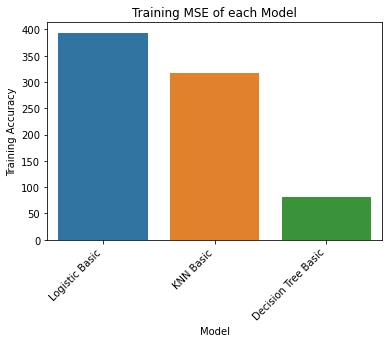

In [205]:
#Plot Training Accuracy of each model on a barplot. Does not appear to be a significant difference now.
fig, ax = plt.subplots()
plot = sns.barplot(data = Comparisondf,x = 'Model', y='Train MSE').set(title = 'Training MSE of each Model', xlabel = 'Model', ylabel = 'Training Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

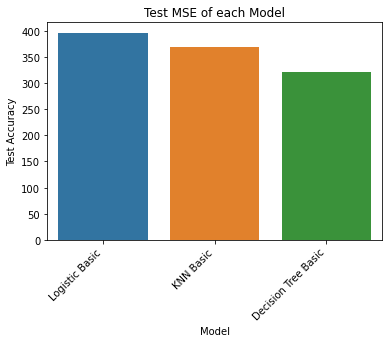

In [206]:
#Plot Test Accuracy of each model on a barplot. Does not appear to be a significant difference now.
fig, ax = plt.subplots()
plot = sns.barplot(data = Comparisondf,x = 'Model', y='Test MSE').set(title = 'Test MSE of each Model', xlabel = 'Model', ylabel = 'Test Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show

Use permutation importance to determine most important features. Accuracy is very low, so will see most important, and collect new dataset based on this.

In [ ]:
r = permutation_importance(kbasic,X_test,y_test,n_repeats=5)
#Permuatation importance, checks which features have the largest impact on the predictions when changed

In [56]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{kbasic.feature_names_in_[i]:<8}"
               f": {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
#Display importances and which features were important

Year of diagnosis: 0.008 +/- 0.002
Age recode with <1 year olds: 0.005 +/- 0.002
Combined Summary Stage (2004+)_Distant: 0.003 +/- 0.001
COD to site recode_Alive: 0.003 +/- 0.001
Sequence number_2nd of 2 or more primaries: 0.001 +/- 0.000
COD to site recode_Diseases of Heart: 0.001 +/- 0.000
Primary Site_502: 0.001 +/- 0.000
Primary Site_649: 0.001 +/- 0.000
Primary Site_182: 0.000 +/- 0.000
COD to site recode_Lung and Bronchus: 0.000 +/- 0.000
Primary Site_443: 0.000 +/- 0.000
COD to site recode_In situ, benign or unknown behavior neoplasm: 0.000 +/- 0.000
COD to site recode_Diabetes Mellitus: 0.000 +/- 0.000
Site recode ICD-O-3/WHO 2008_Esophagus: 0.000 +/- 0.000
Site recode ICD-O-3/WHO 2008_Ascending Colon: 0.000 +/- 0.000
COD to site recode_Intrahepatic Bile Duct: 0.000 +/- 0.000
COD to site recode_Tongue: 0.000 +/- 0.000
Primary Site_501: 0.000 +/- 0.000
COD to site recode_Septicemia: 0.000 +/- 0.000


In [57]:
knnparams = {'n_neighbors':range(1,11),'weights':['uniform','distance']}
knngrid = GridSearchCV(KNeighborsClassifier(),knnparams).fit(X_train,y_train)

In [58]:
dtparams = {'criterion':['gini','entropy'],'max_depth':range(1,5),'min_samples_split':range(2,6)}
dtgrid = GridSearchCV(DecisionTreeClassifier(),dtparams).fit(X_train,y_train)

In [59]:
knngrid.best_score_

0.03905021400316821

In [60]:
dtgrid.best_score_

0.07131635475623624

In [61]:
dtgrid.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [62]:
dbest = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4).fit(X_train,y_train)

In [63]:
r = permutation_importance(dbest,X_test,y_test,n_repeats=5)

In [64]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{dbest.feature_names_in_[i]:<8}"
               f": {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
            
#Not very useful, as year of diagnosis, whether or not patient is alive confound months survived, in my opinion.

Year of diagnosis: 0.030 +/- 0.002
COD to site recode_Alive: 0.027 +/- 0.001
Sequence number_1st of 2 or more primaries: 0.001 +/- 0.001


## Prepare new set of features

In [68]:
#df2 = pd.read_csv('df2small.csv')
#Read in data
#df2 = df2.drop('Unnamed: 0',axis=1)
#df2=df2.dropna()
df2 = pd.read_csv('dataset2.csv')
df2=df2.dropna()
df2,temp = train_test_split(df2, train_size=0.025)

In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201518 entries, 6087335 to 5843372
Data columns (total 16 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   Age recode with <1 year olds            201518 non-null  object
 1   Combined Summary Stage (2004+)          201518 non-null  object
 2   RX Summ--Surg Prim Site (1998+)         201518 non-null  int64 
 3   RX Summ--Scope Reg LN Sur (2003+)       201518 non-null  object
 4   RX Summ--Surg Oth Reg/Dis (2003+)       201518 non-null  object
 5   RX Summ--Reg LN Examined (1998-2002)    201518 non-null  object
 6   Tumor Size Summary (2016+)              201518 non-null  object
 7   Regional nodes positive (1988+)         201518 non-null  int64 
 8   SEER Combined Mets at DX-bone (2010+)   201518 non-null  object
 9   SEER Combined Mets at DX-brain (2010+)  201518 non-null  object
 10  SEER Combined Mets at DX-liver (2010+)  201518 no

### Process new features

In [70]:
df2['Age recode with <1 year olds'] = df2['Age recode with <1 year olds'].apply(AgeReassign)
#Replace previous 'Age Recode' with the reassigned version.

Combined Summary Stage

In [71]:
df2['Combined Summary Stage (2004+)'].unique()

array(['Distant', 'In situ', 'Localized', 'Not coded - Testis',
       'Blank(s)', 'Regional', 'Unknown/unstaged'], dtype=object)

In [72]:
onehotlist2 = []

In [73]:
df2 = df2[df2['Combined Summary Stage (2004+)'] != 'Blank(s)']
df2 = df2[df2['Combined Summary Stage (2004+)'] != 'Unknown/unstaged']
#Drop blanks and unknowns
onehotlist2.append('Combined Summary Stage (2004+)')

Whether primary site had surgery

00 means no surgery.

10-19 are specific codes, whether tumor was destroyed.

20-80 are speciifc codes, resection of pathologic specimen.

90 surgery performed, but no information on which procedure

98 special types of surgery

99 unknown if surgery performed 

126 blank

In [74]:
df2['RX Summ--Surg Prim Site (1998+)'].unique()

array([60, 31, 22, 30, 40, 27,  0, 50, 23, 45, 24, 37, 33, 41, 21, 20, 98,
       52, 57, 99, 51, 59, 26, 25, 47, 42, 32, 46, 70, 48, 44, 14, 54, 90,
       43, 16, 61, 67, 49, 56, 34, 13, 15, 12, 75, 55, 53, 36, 80, 63, 71,
       68, 62, 28, 35, 72, 65, 64, 66, 17, 74, 29, 19, 10, 73, 38, 18, 58,
       77, 11, 69, 78, 76], dtype=int64)

In [75]:
df2 = df2[df2['RX Summ--Surg Prim Site (1998+)'] != 99]
df2 = df2[df2['RX Summ--Surg Prim Site (1998+)'] != 126]
#Drop blanks and unknowns
onehotlist2.append('RX Summ--Surg Prim Site (1998+)')

Lymph Node Surgery 

In [76]:
df2['RX Summ--Reg LN Examined (1998-2002)'].unique()
#Drop because all values are blank

array(['Blank(s)'], dtype=object)

In [77]:
df2 = df2.drop('RX Summ--Reg LN Examined (1998-2002)',axis=1)

Other regions of surgery

In [78]:
df2['RX Summ--Surg Oth Reg/Dis (2003+)'].unique()

array(['None; diagnosed at autopsy',
       'Any combo of sur proc to oth rg, dis lym nd, and/or dis site',
       'Non-primary surgical procedure to other regional sites',
       'Non-primary surgical procedure to distant lymph node(s)',
       'Non-primary surgical procedure to distant site',
       'Non-primary surgical procedure performed',
       'Unknown; death certificate only'], dtype=object)

In [79]:
df2 =df2[df2['RX Summ--Surg Oth Reg/Dis (2003+)'] != 'Unknown; death certificate only']
#Drop unknowns
onehotlist2.append('RX Summ--Surg Oth Reg/Dis (2003+)')

Whether or not regional lymph nodes were examined / removed

In [80]:
df2['RX Summ--Scope Reg LN Sur (2003+)'].unique()

array(['None', 'Unknown or not applicable',
       '4 or more regional lymph nodes removed',
       '1 to 3 regional lymph nodes removed',
       'Biopsy or aspiration of regional lymph node, NOS',
       'Sentinel node biopsy and lym nd removed same/unstated time',
       'Sentinel lymph node biopsy',
       'Number of regional lymph nodes removed unknown',
       'Sentinel node biopsy and lym nd removed different times'],
      dtype=object)

In [81]:
df2 = df2[df2['RX Summ--Scope Reg LN Sur (2003+)'] != 'Unknown or not applicable']
#Drop unknowns

onehotlist2.append('RX Summ--Scope Reg LN Sur (2003+)')

Tumor Size

0 - 988 is exact size

989 is 989 or larger

999 is unknown

1022 is blank

In [82]:
df2 = df2[df2['Tumor Size Summary (2016+)'] != '999']
df2 = df2[df2['Tumor Size Summary (2016+)'] != '1022']
df2 = df2[df2['Tumor Size Summary (2016+)'] != 'Blank(s)']
#Drop blanks and unknowns

df2['Tumor > 989?'] = [i== '989' for i in df2['Tumor Size Summary (2016+)']]
df2['Tumor > 989?']=df2['Tumor > 989?'].map({True:1,False:0})
#Make new column for values larger than 989.

df2['Tumor Size Summary (2016+)']=df2['Tumor Size Summary (2016+)'].apply(float)
#Convert to numerical values

Regional Nodes

0-89 is number of positive nodes

90: 90+ nodes are positive

95: positive aspiration of nodes performed

97: positive nodes documented, number unspecified

98: no nodes examined

99: Unknown

126: blank

In [83]:
df2['Regional nodes positive (1988+)'].unique()

array([98,  0, 95,  4,  1,  3,  6, 24, 33,  2,  9, 99,  8,  5, 10, 12, 97,
        7, 18, 11, 13, 14, 16, 34, 25, 17, 30, 19, 26, 15, 21, 31, 20, 38,
       27, 22, 23, 32, 75, 40, 29, 54, 44, 37, 39], dtype=int64)

In [84]:
df2 = df2[df2['Regional nodes positive (1988+)'] != 99]
df2 = df2[df2['Regional nodes positive (1988+)'] != 126]
#Drop blanks and unknowns

df2['nodes > 90'] = [i== 90 for i in df2['Regional nodes positive (1988+)']]
df2['nodes > 90']=df2['nodes > 90'].map({True:1,False:0})
#Make new column to state if nodes over 90.

Metastasis at Bone

In [85]:
df2['SEER Combined Mets at DX-bone (2010+)'].unique()

array(['No', 'Yes', 'Unknown'], dtype=object)

In [86]:
df2 = df2[df2['SEER Combined Mets at DX-bone (2010+)']!= 'Unknown']
#Drop unknowns
df2['SEER Combined Mets at DX-bone (2010+)'] = df2['SEER Combined Mets at DX-bone (2010+)'].map({'No':0,'Yes':1})
#Map to binary numerical

Metastasis at Brain

In [87]:
df2['SEER Combined Mets at DX-brain (2010+)'].unique()

array(['No', 'Yes', 'Unknown'], dtype=object)

In [88]:
df2 = df2[df2['SEER Combined Mets at DX-brain (2010+)']!= 'Unknown']
#Drop unknowns
df2['SEER Combined Mets at DX-brain (2010+)'] = df2['SEER Combined Mets at DX-brain (2010+)'].map({'No':0,'Yes':1})
#Map to binary numerical

Metastasis at Liver

In [89]:
df2['SEER Combined Mets at DX-liver (2010+)'].unique()

array(['No', 'Yes', 'Unknown'], dtype=object)

In [90]:
df2 = df2[df2['SEER Combined Mets at DX-liver (2010+)']!= 'Unknown']
#Drop unknowns
df2['SEER Combined Mets at DX-liver (2010+)'] = df2['SEER Combined Mets at DX-liver (2010+)'].map({'No':0,'Yes':1})
#Map to binary numerical

Metastasis at Lung

In [91]:
df2['SEER Combined Mets at DX-lung (2010+)'].unique()

array(['No', 'Yes', 'Unknown'], dtype=object)

In [92]:
df2 = df2[df2['SEER Combined Mets at DX-lung (2010+)']!= 'Unknown']
#Drop unknowns
df2['SEER Combined Mets at DX-lung (2010+)'] = df2['SEER Combined Mets at DX-lung (2010+)'].map({'No':0,'Yes':1})
#Map to binary numerical

Extent of Disease

In [93]:
df2['EOD 10 - extent (1988-2003)'].unique()

array(['Blank(s)'], dtype=object)

In [94]:
df2['EOD 10 - nodes (1988-2003)'].unique()

array(['Blank(s)'], dtype=object)

In [95]:
df2['EOD 10 - size (1988-2003)'].unique()

array(['Blank(s)'], dtype=object)

In [96]:
df2 = df2.drop(['EOD 10 - extent (1988-2003)','EOD 10 - nodes (1988-2003)','EOD 10 - size (1988-2003)'],axis = 1)
#Drop these three features since they are all blanks

In [97]:
df2['Survival months'].unique()

array(['0042', '0017', '0004', '0000', '0009', '0018', '0015', '0005',
       '0002', '0023', '0021', '0037', '0028', '0003', '0026', '0022',
       '0014', '0008', '0019', '0031', '0001', '0010', '0025', '0020',
       '0013', '0006', '0030', '0011', '0040', '0045', '0036', '0007',
       '0032', '0035', '0027', '0044', '0016', '0034', '0043', '0012',
       '0033', '0046', '0024', '0029', '0039', '0041', '0038', '0047',
       'Unknown'], dtype=object)

In [98]:
df2 = df2[df2['Survival months'] != 'Unknown']
#Drop unknowns. These wouldn't have been able to be converted to float as well. They are also not useful to the model.

In [99]:
df2['Survival months'] = [float(i) for i in df2['Survival months']]
#Replace strings with corresponding float.

In [100]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19029 entries, 5463430 to 5843372
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age recode with <1 year olds            19029 non-null  float64
 1   Combined Summary Stage (2004+)          19029 non-null  object 
 2   RX Summ--Surg Prim Site (1998+)         19029 non-null  int64  
 3   RX Summ--Scope Reg LN Sur (2003+)       19029 non-null  object 
 4   RX Summ--Surg Oth Reg/Dis (2003+)       19029 non-null  object 
 5   Tumor Size Summary (2016+)              19029 non-null  float64
 6   Regional nodes positive (1988+)         19029 non-null  int64  
 7   SEER Combined Mets at DX-bone (2010+)   19029 non-null  int64  
 8   SEER Combined Mets at DX-brain (2010+)  19029 non-null  int64  
 9   SEER Combined Mets at DX-liver (2010+)  19029 non-null  int64  
 10  SEER Combined Mets at DX-lung (2010+)   19029 non-

In [101]:
onehot2 = OneHotEncoder(drop = 'if_binary')
#Fit and transform columns to OneHotEncoder, based on the features I chose to encode via onehotencoder.
array2 = onehot2.fit_transform(df2[onehotlist2]).toarray()
#Store array to variable array to later make dataframe.
names2= onehot2.get_feature_names_out(onehotlist2)
#Get feature names for dataframe columns
onehotdf2 = pd.DataFrame(array2)
#Make dataframe from array
onehotdf2.columns = names2
#Set column labels

ddf = df2.reset_index().drop(onehotlist2,axis=1).join(onehotdf2)
#ddf as in 'done'df. Reset index and drop original columns encoded by onehotencoder, then combine with the encoded columns
ddf = ddf.drop('index',axis=1)

In [102]:
ddf

,Age recode with <1 year olds,Tumor Size Summary (2016+),Regional nodes positive (1988+),SEER Combined Mets at DX-bone (2010+),SEER Combined Mets at DX-brain (2010+),SEER Combined Mets at DX-liver (2010+),SEER Combined Mets at DX-lung (2010+),Survival months,Tumor > 989?,nodes > 90,...,RX Summ--Surg Oth Reg/Dis (2003+)_Non-primary surgical procedure to other regional sites,RX Summ--Surg Oth Reg/Dis (2003+)_None; diagnosed at autopsy,RX Summ--Scope Reg LN Sur (2003+)_1 to 3 regional lymph nodes removed,RX Summ--Scope Reg LN Sur (2003+)_4 or more regional lymph nodes removed,"RX Summ--Scope Reg LN Sur (2003+)_Biopsy or aspiration of regional lymph node, NOS",RX Summ--Scope Reg LN Sur (2003+)_None,RX Summ--Scope Reg LN Sur (2003+)_Number of regional lymph nodes removed unknown,RX Summ--Scope Reg LN Sur (2003+)_Sentinel lymph node biopsy,RX Summ--Scope Reg LN Sur (2003+)_Sentinel node biopsy and lym nd removed different times,RX Summ--Scope Reg LN Sur (2003+)_Sentinel node biopsy and lym nd removed same/unstated time
0,37.0,37.0,98,0,0,0,0,42.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,85.0,49.0,98,0,0,0,0,17.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,67.0,35.0,0,0,0,0,0,4.0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,65.0,98,0,0,0,0,0.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,72.0,82.0,95,0,0,0,0,9.0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19024,32.0,32.0,5,0,0,0,0,39.0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19025,82.0,5.0,0,0,0,0,0,15.0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19026,67.0,130.0,98,0,0,0,0,41.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19027,67.0,50.0,0,0,0,0,0,24.0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Analysis

In [103]:
survcorr = ddf.corr()['Survival months']
#Get correlation of all values with survival months to get an idea of the most important columns, since will be predicting this.

In [104]:
abs(survcorr).sort_values(ascending=False)
#Highest absolute correlations are year of diagnosis, which makes sense, but is fairly useless since we expect to see this, and whether or not the patient is currently alive, which also makes sense as we would expect shorter lived patients to have likely already died. 
#Consider dropping both of these columns, or at least year.

Survival months                             1.000000
RX Summ--Surg Prim Site (1998+)_0           0.318514
Combined Summary Stage (2004+)_Distant      0.291200
SEER Combined Mets at DX-liver (2010+)      0.191292
Combined Summary Stage (2004+)_Localized    0.176131
                                              ...   
RX Summ--Surg Prim Site (1998+)_56          0.002103
RX Summ--Surg Prim Site (1998+)_42          0.001362
RX Summ--Surg Prim Site (1998+)_65          0.000692
RX Summ--Surg Prim Site (1998+)_43          0.000509
nodes > 90                                       NaN
Name: Survival months, Length: 87, dtype: float64

#### Split data for analysis

In [105]:
train, test = train_test_split(ddf)
#Train test split of the processed dataframe

X_train = train.drop('Survival months',axis=1)
X_test = test.drop('Survival months', axis=1)
y_train = train['Survival months']
y_test = test['Survival months']

In [106]:
ddf

,Age recode with <1 year olds,Tumor Size Summary (2016+),Regional nodes positive (1988+),SEER Combined Mets at DX-bone (2010+),SEER Combined Mets at DX-brain (2010+),SEER Combined Mets at DX-liver (2010+),SEER Combined Mets at DX-lung (2010+),Survival months,Tumor > 989?,nodes > 90,...,RX Summ--Surg Oth Reg/Dis (2003+)_Non-primary surgical procedure to other regional sites,RX Summ--Surg Oth Reg/Dis (2003+)_None; diagnosed at autopsy,RX Summ--Scope Reg LN Sur (2003+)_1 to 3 regional lymph nodes removed,RX Summ--Scope Reg LN Sur (2003+)_4 or more regional lymph nodes removed,"RX Summ--Scope Reg LN Sur (2003+)_Biopsy or aspiration of regional lymph node, NOS",RX Summ--Scope Reg LN Sur (2003+)_None,RX Summ--Scope Reg LN Sur (2003+)_Number of regional lymph nodes removed unknown,RX Summ--Scope Reg LN Sur (2003+)_Sentinel lymph node biopsy,RX Summ--Scope Reg LN Sur (2003+)_Sentinel node biopsy and lym nd removed different times,RX Summ--Scope Reg LN Sur (2003+)_Sentinel node biopsy and lym nd removed same/unstated time
0,37.0,37.0,98,0,0,0,0,42.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,85.0,49.0,98,0,0,0,0,17.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,67.0,35.0,0,0,0,0,0,4.0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,65.0,98,0,0,0,0,0.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,72.0,82.0,95,0,0,0,0,9.0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19024,32.0,32.0,5,0,0,0,0,39.0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19025,82.0,5.0,0,0,0,0,0,15.0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19026,67.0,130.0,98,0,0,0,0,41.0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19027,67.0,50.0,0,0,0,0,0,24.0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Comparison of a Few Models

LR first tiral

In [187]:
#Build very basic model, fit to training data.
start =time.time()
lr = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
lrtraintime =time.time() - start
#Find scores of logistic regression predictions

lrtrainscore =  mean_squared_error(y_train,lr.predict(X_train))
lrtestscore =  mean_squared_error(y_test,lr.predict(X_test))

print('Logistic Train Accuracy: ' + str(lrtrainscore) + '\nLogistic Test Accuracy: ' + str(lrtestscore))

#Format data for dataframe later
lrdata = ['Logistic Basic', lrtrainscore, lrtestscore, lrtraintime]

Logistic Train Accuracy: 393.8811575923201
Logistic Test Accuracy: 397.208280790248


C:\Users\timmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN first trial

In [188]:
#Fit and score basic KNN algorithm
#Find current time
start = time.time()
#Train model by fitting data
kbasic = KNeighborsClassifier().fit(X_train,y_train)
#Calculate time taken to fit data
kbtraintime = time.time() - start

#Get mean_squared_error from training and testing
kbtrainscore =  mean_squared_error(y_train,kbasic.predict(X_train))
kbtestscore =  mean_squared_error(y_test,kbasic.predict(X_test))
#Format data for dataframe later
kbdata = ['KNN Basic', kbtrainscore, kbtestscore, kbtraintime]
print('KNN Basic Train Accuracy: ' + str(kbtrainscore) + '\nKNN Basic Test Accuracy: ' + str(kbtestscore) + '\nTrain Time: ' + str(kbtraintime))

KNN Basic Train Accuracy: 317.7210426739542
KNN Basic Test Accuracy: 369.83375367801597
Train Time: 0.005005598068237305


Decision Tree first trial

In [189]:
#Fit and score basic Decision Tree model
#Find current time
start = time.time()
#Train model by fitting data
dbasic = DecisionTreeClassifier().fit(X_train, y_train)
#Calculate time taken to fit data
dbtime = time.time() - start

#Get mean square error from training and testing
dbtrainscore = mean_squared_error(y_train, dbasic.predict(X_train))
dbtestscore =  mean_squared_error(y_test, dbasic.predict(X_test))
#Format data for dataframe later
dbdata = ['Decision Tree Basic',dbtrainscore, dbtestscore, dbtime]
print('Decision Tree Basic Train Accuracy: ' + str(dbtrainscore) + '\nDecision Tree Basic Test Accuracy: ' + str(dbtestscore) + '\nTrain Time ' + str(dbtime))

Decision Tree Basic Train Accuracy: 81.4453787401023
Decision Tree Basic Test Accuracy: 324.23287095418243
Train Time 0.08366250991821289


SVM first trial

In [190]:
#Fit and score basic SVM model
#Find current time
start = time.time()
#Train model by fitting data
sbasic = SVC().fit(X_train,y_train)
#Calculate time taken to fit data
sbtime = time.time() - start

#Get  mean_squared_error from training and testing
sbtrainscore =  mean_squared_error(y_train, sbasic.predict(X_train))
sbtestscore =  mean_squared_error(y_test, sbasic.predict(X_test))
#Format data for dataframe later
sbdata = ['SVM Basic',sbtrainscore,sbtestscore,sbtime]
print('SVM Basic Train Accuracy: ' + str(sbtrainscore) + '\nSVM Basic Test Accuracy ' + str(sbtestscore) + '\nTrain Time ' + str(sbtime))

SVM Basic Train Accuracy: 463.748861327167
SVM Basic Test Accuracy 474.28793610760823
Train Time 18.150750875473022


In [202]:
Comparisondf = (pd.DataFrame([lrdata,kbdata, dbdata,sbdata]))
Comparisondf.columns = ['Model','Train MSE','Test MSE','Train Time']
Comparisondf

,Model,Train MSE,Test MSE,Train Time
0,Logistic Basic,393.881158,397.208281,17.366961
1,KNN Basic,317.721043,369.833754,0.005428
2,Decision Tree Basic,81.445379,321.354140,0.084164
3,SVM Basic,463.748861,474.287936,18.115092


<function matplotlib.pyplot.show(close=None, block=None)>

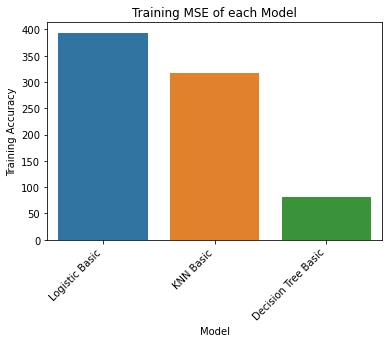

In [207]:
#Plot Training Accuracy of each model on a barplot. Does not appear to be a significant difference now.
fig, ax = plt.subplots()
plot = sns.barplot(data = Comparisondf,x = 'Model', y='Train MSE').set(title = 'Training MSE of each Model', xlabel = 'Model', ylabel = 'Training Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

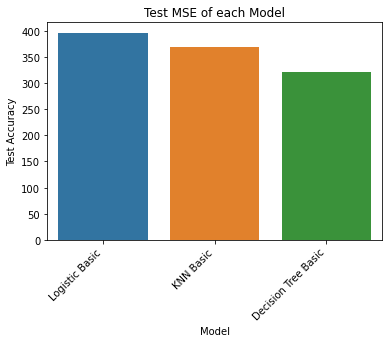

In [208]:
#Plot Test Accuracy of each model on a barplot. Does not appear to be a significant difference now.
fig, ax = plt.subplots()
plot = sns.barplot(data = Comparisondf,x = 'Model', y='Test MSE').set(title = 'Test MSE of each Model', xlabel = 'Model', ylabel = 'Test Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show

Use permutation importance to determine most important features. Accuracy is very low, so will see most important, and collect new dataset based on this.

In [114]:
r = permutation_importance(kbasic,X_test,y_test,n_repeats=5)
#Permuatation importance, checks which features have the largest impact on the predictions when changed

In [115]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{kbasic.feature_names_in_[i]:<8}"
               f": {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
#Display importances and which features were important

SEER Combined Mets at DX-brain (2010+): 0.002 +/- 0.000
SEER Combined Mets at DX-liver (2010+): 0.001 +/- 0.000
RX Summ--Surg Prim Site (1998+)_50: 0.001 +/- 0.001
Tumor Size Summary (2016+): 0.001 +/- 0.001
RX Summ--Scope Reg LN Sur (2003+)_4 or more regional lymph nodes removed: 0.001 +/- 0.000
RX Summ--Surg Prim Site (1998+)_31: 0.001 +/- 0.000


Gridsearch of KNN and Decision Trees because they have the best training accuracy, since all have very low test accuracy. Might be able to reduce overfitting to get something working.

In [116]:
knnparams = {'n_neighbors':range(1,11),'weights':['uniform','distance']}
#Parameters for KNN parameters to look through in grid search.

knngrid = GridSearchCV(KNeighborsClassifier(),knnparams).fit(X_train,y_train)

In [132]:
knngrid.best_params_
#Get best parameters

{'n_neighbors': 5, 'weights': 'uniform'}

In [118]:
knngrid.best_score_
#Best score still very low... perhaps these features are not predictive of the data.

0.04856008158887211

In [117]:
dtparams = {'criterion':['gini','entropy'],'max_depth':range(1,5),'min_samples_split':range(2,6)}
dtgrid = GridSearchCV(DecisionTreeClassifier(),dtparams).fit(X_train,y_train)

In [119]:
dtgrid.best_score_

0.06271484271928543

In [120]:
dtgrid.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [121]:
dbest = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, min_samples_split=2).fit(X_train,y_train)

In [122]:
r = permutation_importance(dbest,X_test,y_test,n_repeats=5)

In [123]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{dbest.feature_names_in_[i]:<8}"
               f": {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

RX Summ--Surg Prim Site (1998+)_0: 0.008 +/- 0.001


### Linear Regresssion Model

In [124]:
lr = LinearRegression().fit(X_train,y_train)
#Fit model using linear regression, as other models appear to have very high errors

In [125]:
msetrain = mean_squared_error(lr.predict(X_train),y_train)
msetest = mean_squared_error(lr.predict(X_test),y_test)

In [126]:
msetrain

162.29408975026138

In [127]:
msetest

165.6224161742566

Determine best degree to use based on how error of trains and tests change.

In [129]:
msetrains = []
msetests = []
degrees = []
for i in range(1,4):
#Column transformer, polynomial degree of all numerical columns, onehotencoder for the categorical values that can't really be ordered, ordinalencoder for the columns that can be ordered somewhat.
    trans = make_column_transformer((PolynomialFeatures(degree=i), make_column_selector(dtype_include=np.number)))
    #Create pipeline to transform and model as linear regression
    pipe = Pipeline([
        ('poly', trans),
        ('model', LinearRegression())
    ])
    #Fit model using training data
    pipe.fit(X_train,y_train)
    #Calculate mean squared errors
    msetrain = mean_squared_error(pipe.predict(X_train),y_train)
    msetest = mean_squared_error(pipe.predict(X_test),y_test)
    msetrains.append(msetrain)
    msetests.append(msetest)
    degrees.append(i)
 #   print('Training MSE: ' + str(msetrain) +'\nTest MSE: ' + str(msetest))

[Text(0.5, 1.0, 'Mean Squared Error vs. Polynomial Degree'),
 Text(0.5, 0, 'Polynomial Degree'),
 Text(0, 0.5, 'MSE * 10 **7')]

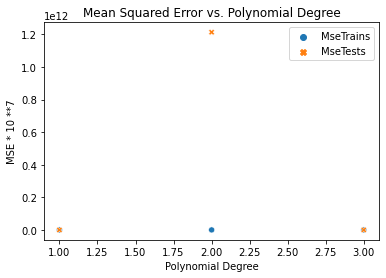

In [130]:
msedf = pd.DataFrame(msetrains,degrees)
msedf.columns = ['MseTrains']
msedf['MseTests'] = msetests
sns.scatterplot(data=msedf).set(title = 'Mean Squared Error vs. Polynomial Degree', xlabel = 'Polynomial Degree',ylabel = 'MSE * 10 **7')
#Looks like 1 or 3 degrees is the best, so will use that for model. Has the effect where overfitting by a lot results in it going back down
#When compared with test data, training MSEs not too far off, so doesn't seem to be overtrained

Degree 3 linear regression

In [135]:
trans = make_column_transformer((PolynomialFeatures(degree=3), make_column_selector(dtype_include=np.number)))
#Create pipeline to transform and model as linear regression, attempt degree 3 since similare MSE for this one.
pipe = Pipeline([
    ('poly', trans),
    ('model', LinearRegression())
    ])
#Fit model using training data
pipe.fit(X_train,y_train)
pipe.score(X_train,y_train)

0.27144271514983453

In [136]:
pipe.score(X_test,y_test)
#Test score for degree 3. Very low.

-153415.2110326754

Degree 1 linear regression

In [137]:
trans = make_column_transformer((PolynomialFeatures(degree=1), make_column_selector(dtype_include=np.number)))
#Create pipeline to transform and model as linear regression. Attempt degree 1 since similarly low MSE for test and train.
pipe = Pipeline([
    ('poly', trans),
    ('model', LinearRegression())
    ])
#Fit model using training data
pipe.fit(X_train,y_train)
pipe.score(X_train,y_train)

0.14762171820229453

In [138]:
pipe.score(X_test, y_test)
#Test score 

0.14446632635954137

In [184]:
featurecoefdict = {}
for i in range(0,len(pipe['poly'].get_feature_names_out())):
    featurecoefdict[pipe['poly'].get_feature_names_out()[i]] =  abs(pipe['model'].coef_[i])
    
#Shows coefficients and what features they correspond to. 

sortdict = sorted(featurecoefdict, key=featurecoefdict.get)
#Sort Dictionary

for i in sortdict[-5:]:
    print(i + ': ' + str(featurecoefdict[i]))
#Print highest absolute coefficent (most influential values)

polynomialfeatures__RX Summ--Surg Prim Site (1998+)_38: 8.297374305808846
polynomialfeatures__RX Summ--Surg Prim Site (1998+)_10: 10.646662853865752
polynomialfeatures__RX Summ--Surg Prim Site (1998+)_19: 11.616846475254713
polynomialfeatures__Tumor > 989?: 15.702190939950686
polynomialfeatures__RX Summ--Surg Prim Site (1998+)_66: 18.861056255777353


## Results

After processing the data, fitting and comparing various models and assessing features to use, I ultimately found that a linear regression model appeared to best model the data possibly due to there being too little difference between each 'class' of survival months (with a class being each integer value), resulting in large amounts of misclassification. Although none of the classification models fit the data very well, KNN and Decision Tree were the best and from these, combined metastasis and surgery site appeared to have the greatest influence on survival months. Linear regression, however, proved to be a much better fit, with a much lower overall test mean squared error.

Although I still had a very high mean square error, I think the Linear Regression Model performed the best overall, and the most influential feature was the Surgery site, as it had the highest coefficients.

Future analysis of the data could focus on Linear Regression and explore additional new features from the SEER data, as there are many more left unexplored. In addition, the specific surgery sites that have the greatest influence on survival months could be explored to get an idea of what types of cancer are more or less dangerous to patients, or which surgeries are more effective. 